Show how UK demand for products has evolved over time.

First, show the origins of **UK demand** -- total, the part that comes from UK manufacturing, and the part of that that actually comes from UK steel.

Then show **UK manufacturing** -- the total, then excluding imported components, then excluding imported steel products.

In [1]:
import pandas as pd
flows = pd.read_csv('../data/flows.csv')

In [2]:
from palettable.cartocolors.qualitative import Prism_10, Antique_10
from palettable.colorbrewer.qualitative import Set3_7
C = Prism_10.hex_colors[1:]

colors = ['black'] + Set3_7.hex_colors[4:]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
sectors = ['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15a', '15b', '16', '17', '18', '19', '20']

sector_ids = ['sector %s' % s for s in sectors]

sector_names = [
    'Fasteners',
    'Hand tools, cutlery, instruments',
    'Packaging, industrial/domestic hollow-ware',
    'Other metal goods',
    'Electrical engineering, incl. appliances',
    'Agricultural machinery',
    'Metal working tools & engineering tools',
    'Construction, earth moving & handling equipment',
    'Other mechanical engineering',
    'Industrial & process plant',
    'Construction & fabricated steelwork',
    'Motor vehicles: BIW',
    'Motor vehicles: drivetrain, chassis, trimmings',
    'Other transport',
    'Coal, coke, petroleum & natural gas',
    'Gas, electricity & water',
    'Chemical & allied industries',
    'Other UK consumers'
]

sector_groups = [
    ('Metal goods', ['4', '5', '6', '7']),
    ('Elec. eng', ['8']),
    ('Mech. eng', ['9', '10', '11', '12', '13']),
    ('Construction', ['14']),
    ('Transport', ['15a', '15b', '16']),
    ('Energy/water', ['17', '18', '19']),
    ('Other', ['20']),
]

In [5]:
# from https://stackoverflow.com/a/49601444/1615465
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [6]:
palette = {k[0]: '#999' for k in sector_groups}
palette['Metal goods'] = C[0]
palette['Elec. eng'] = C[1]
palette['Mech. eng'] = C[2]
palette['Construction'] = C[3]
palette['Transport'] = C[4]
palette['Energy/water'] = C[5]
palette['Other'] = C[6]

palette2 = []
for k, grp in sector_groups:
    for i in range(len(grp)):
        palette2.append(palette[k] if i % 2 else lighten_color(palette[k], 0.9))

Calculate the different parts of the flows:

In [7]:
# These are the flows from all sources into UK manufacturing
inputs = flows.query('target in @sector_ids').copy()
inputs['material'] = inputs['target'].str.lstrip('sector ')  # convert "sector 4" to just "4"
inputs = inputs.groupby(['year', 'material', 'source'])['value'].sum().unstack()

# These are the later flows of imported goods into UK demand
imported_final = flows.query('source == "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

# And these are the flows from UK manufacturing to UK demand
uk_manufac = flows.query('target == "uk_demand" and source != "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

# Collect results together
scale = (uk_manufac / inputs.sum(axis=1))
results = pd.DataFrame({
    'UK produced steel':       scale * inputs['uk_production'],
    'Imported as semis':       scale * inputs['imports'],
    'Imported as components':  scale * inputs['component_imports'],
    'Imported as final goods': imported_final,
}).fillna(0)

results_manufac = pd.DataFrame({
    'UK produced steel':       inputs['uk_production'],
    'Imported as semis':       inputs['imports'],
    'Imported as components':  inputs['component_imports'],
}).fillna(0)

# Unstack, sort sectors and convert to Mt, then unstack
results = results.reindex(sectors[::-1], level='material').unstack() / 1e3
results_manufac = results_manufac.reindex(sectors[::-1], level='material').unstack() / 1e3

results.head()

UK produced steel                                               \
material                20        19        18        17   16       15b   
year                                                                      
1980                0.6406  0.004038  0.089480  0.107543  0.0  0.099965   
1981                0.7178  0.003333  0.099824  0.119041  0.0  0.135065   
1982                0.6854  0.003133  0.097121  0.116970  0.0  0.146774   
1983                0.6304  0.002946  0.092966  0.113415  0.0  0.158273   
1984                0.7091  0.003067  0.108484  0.134005  0.0  0.198042   

                                                   ...    \
material       15a        14        13        12   ...     
year                                               ...     
1980      0.010801  2.530511  0.050629  0.018048   ...     
1981      0.051115  2.886232  0.092900  0.029553   ...     
1982      0.063622  2.586716  0.076424  0.008887   ...     
1983      0.031066  3.112879  0.073280  0.050313   ...     
1984      0.044245  3.109834  0.087116  0.085870   ...     

         Imported as final goods                                          \
material                      13      12      11      10       9       8   
year                                                                       
1980                      0.1225  0.2051  0.1285  0.0574  0.0708  0.0991   
1981                      0.0766  0.1897  0.1129  0.0384  0.0731  0.1128   
1982                      0.0864  0.2172  0.1298  0.0405  0.1002  0.6405   
1983                      0.0881  0.2178  0.1377  0.0341  0.1062  0.1504   
1984                      0.1022  0.2510  0.1549  0.0424  0.1036  0.1761   

                                          
material       7       6       5       4  
year                                      
1980      0.1286  0.0564  0.1393  0.0670  
1981      0.1298  0.0193  0.1211  0.0594  
1982      0.1402  0.0287  0.2877  0.0792  
1983      0.1527  0.0282  0.1338  0.0805  
1984      0.1750  0.0341  0.1531  0.0970  

[5 rows x 72 columns]

## UK demand

These are the three stages we want to show:
1. UK demand supplied from domestic steel through domestic manufacturing
2. UK demand supplied from domestic manufacturing (including imported steel products and components)
3. UK demand (including imported final goods)

In [8]:
dom_demand_dom_steel = results['UK produced steel']

dom_demand = (dom_demand_dom_steel + 
              results['Imported as semis'] +
              results['Imported as components'])

all_demand = (dom_demand +
              results['Imported as final goods'])

In [9]:
def plot_stacked(df, title=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.stackplot(df.index.values, df.values.T, colors=palette2[::-1]);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(1980, 2016)
    ax.set_ylim(0, 20)
    ax.set_ylabel('Mt')
    ax.set_title(title)

    y1 = df.loc[2016, sectors[::-1]]
    y = 0
    for dy, name, c in zip(y1, sector_names[::-1], palette2[::-1]):
        y += dy / 2
        if dy > 0.4:
            ax.text(2016.1, y, name, va='center', color=c)
        y += dy / 2
    
    return fig, ax

def add_total_line(ax, df, title):
    """Add a line and label showing the total of another dataset."""
    ax.plot(df.index, df.sum(axis=1), 'k', lw=1.5, alpha=0.8)
    ax.text(2016.1, df.sum(axis=1).values[-1], title, va='center', fontstyle='italic')

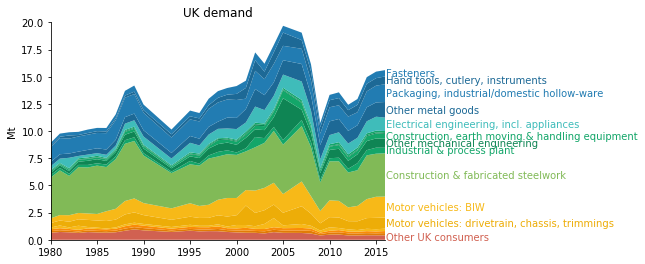

In [10]:
fig, ax = plot_stacked(all_demand, title='UK demand')
fig.savefig('../figures/uk_demand_over_time.pdf', bbox_inches='tight')

Perhaps also only the domestically-satisfied demand, excluding imports:

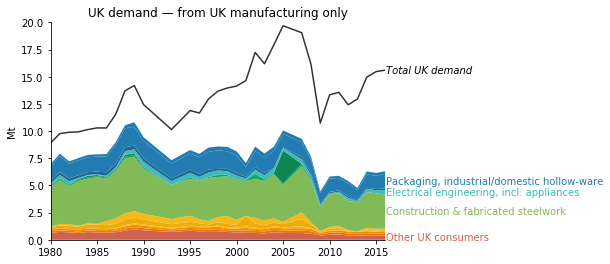

In [11]:
fig, ax = plot_stacked(dom_demand, 'UK demand — from UK manufacturing only')
add_total_line(ax, all_demand, 'Total UK demand')
fig.savefig('../figures/uk_demand_over_time_excluding_imports_same_scale.pdf', bbox_inches='tight')

And now only the part of UK manufactured products that were made from UK steel

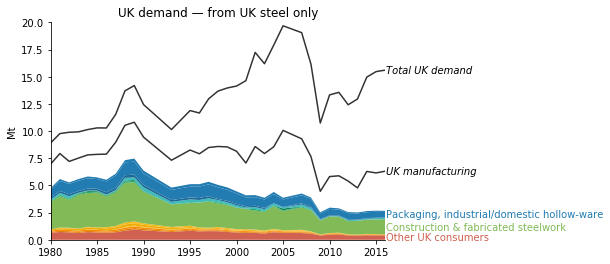

In [12]:
fig, ax = plot_stacked(dom_demand_dom_steel, title='UK demand — from UK steel only')
add_total_line(ax, all_demand, 'Total UK demand')
add_total_line(ax, dom_demand, 'UK manufacturing')
fig.savefig('../figures/uk_demand_over_time_uk_only_same_scale.pdf', bbox_inches='tight')

Scale ranges

In [13]:
results.max()[['Imported as semis', 'Imported as components', 'Imported as final goods']].sum(level=1).max()

3.814837404580153

In [14]:
results.max()['UK produced steel'].max()

3.6634693720063862

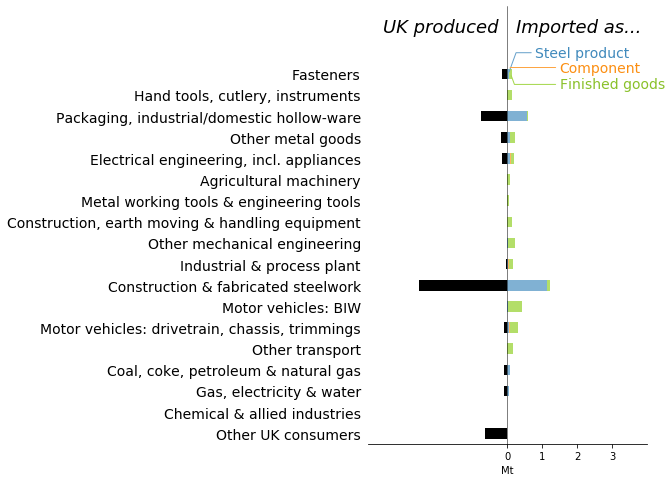

In [15]:
df = results.copy()
df['UK produced steel'] *= -1

import numpy as np
def plot_origin(year):
    fig, ax = plt.subplots(figsize=(5, 7))
    df.loc[year].unstack(level=0).plot.barh(stacked=True, ax=ax, color=colors, legend=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.axvline(0, ymax=1.15, color='k', lw=0.5, clip_on=False)
    ax.set_yticklabels(sector_names[::-1], fontsize=14);
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlim(-4, 4)
    ax.set_xlabel('Mt')
    ax.set_ylabel('');
    ax.text(-0.25, 19, 'UK produced', fontsize=18, fontstyle='italic', ha='right')
    ax.text( 0.25, 19, 'Imported as...', fontsize=18, fontstyle='italic', ha='left')

    def annot(text, xy, xytext, color, **kwargs):
        ab = 70 if xytext[1] > xy[1] else 110
        ax.annotate(text, xy, xytext, annotation_clip=False, color=lighten_color(color, 1.5), fontsize=14,
                    arrowprops=dict(arrowstyle='-', color=lighten_color(color, 1.2),
                                    connectionstyle="angle,angleA=0,angleB=%d,rad=0" % ab), **kwargs)

    edges = np.r_[0, df.loc[year].xs('4', level='material').iloc[1:].cumsum()]
    midpoints = (edges[0:-1] + edges[1:]) / 2

    annot('Steel product', (midpoints[0], 17), (0.8, 18.0), colors[1], va='center')
    annot('Component', (midpoints[1], 17.2), (1.5, 17.3), colors[2], ha='left', va='center')
    annot('Finished goods', (midpoints[2], 17.0), (1.5, 16.5), colors[3], ha='left', va='center')
    return fig, ax

fig, ax = plot_origin(1980)
#fig.savefig('../figures/uk_final_goods_origin.pdf', bbox_inches='tight')

In [16]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('../figures/uk_final_goods_origin_years.pdf') as pdf:
    for year in range(1980, 2017):
        try:
            df.loc[year]
        except KeyError:
            print('Skipping year %d' % year)
        else:
            fig, ax = plot_origin(year)
            fig.text(0, 0, year, fontsize=18)
            #fig.savefig('../figures/uk_final_goods_origin_%s.pdf' % year, bbox_inches='tight')
            pdf.savefig(bbox_inches='tight')
            plt.close(fig)

Skipping year 1991
Skipping year 1992
Skipping year 1994
Skipping year 2006


## UK Manufacturing

Now show only the UK manufacturing output, in these stages:

1. All UK manufacturing
2. UK manufacturing, excluding imported components
3. UK manufacturing from UK produced steel (excluding imported components and steel products)

In [17]:
manufac_dom_steelmaking = results_manufac['UK produced steel']

manufac_dom_steel = (manufac_dom_steelmaking + 
                     results_manufac['Imported as semis'])

manufac = (manufac_dom_steel +
           results_manufac['Imported as components'])

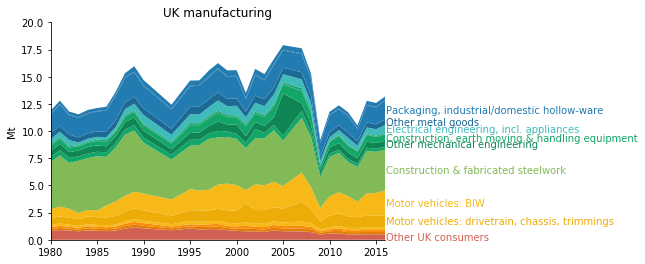

In [18]:
fig, ax = plot_stacked(manufac, title='UK manufacturing')
fig.savefig('../figures/uk_manufac_all.pdf', bbox_inches='tight')

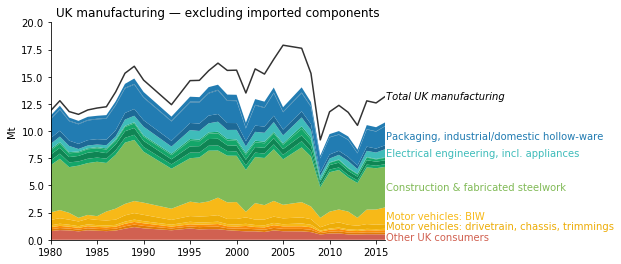

In [19]:
fig, ax = plot_stacked(manufac_dom_steel, 'UK manufacturing — excluding imported components')
add_total_line(ax, manufac, 'Total UK manufacturing')
fig.savefig('../figures/uk_manufac_excl_components.pdf', bbox_inches='tight')

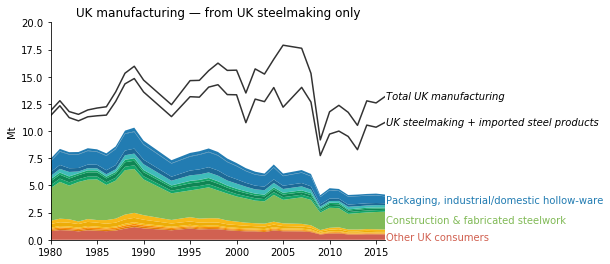

In [20]:
fig, ax = plot_stacked(manufac_dom_steelmaking, 'UK manufacturing — from UK steelmaking only')
add_total_line(ax, manufac, 'Total UK manufacturing')
add_total_line(ax, manufac_dom_steel, 'UK steelmaking + imported steel products')
fig.savefig('../figures/uk_manufac_uk_steel.pdf', bbox_inches='tight')

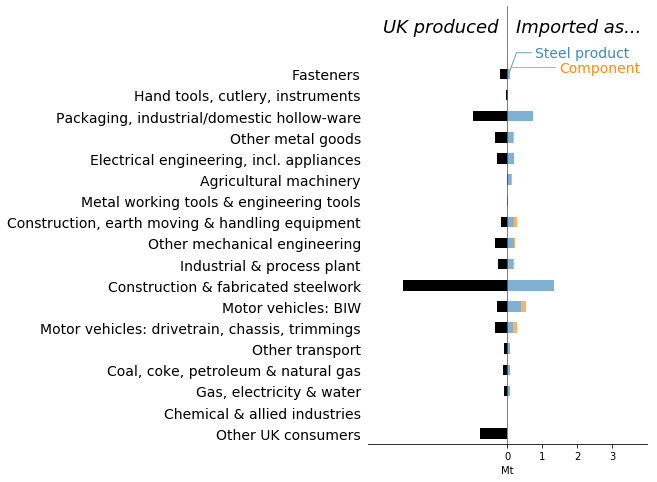

In [21]:
df = results_manufac.copy()
df['UK produced steel'] *= -1

def plot_origin(year):
    fig, ax = plt.subplots(figsize=(5, 7))
    df.loc[year].unstack(level=0).plot.barh(stacked=True, ax=ax, color=colors, legend=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.axvline(0, ymax=1.15, color='k', lw=0.5, clip_on=False)
    ax.set_yticklabels(sector_names[::-1], fontsize=14);
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlim(-4, 4)
    ax.set_xlabel('Mt')
    ax.set_ylabel('');
    ax.text(-0.25, 19, 'UK produced', fontsize=18, fontstyle='italic', ha='right')
    ax.text( 0.25, 19, 'Imported as...', fontsize=18, fontstyle='italic', ha='left')

    def annot(text, xy, xytext, color, **kwargs):
        ab = 70 if xytext[1] > xy[1] else 110
        ax.annotate(text, xy, xytext, annotation_clip=False, color=lighten_color(color, 1.5), fontsize=14,
                    arrowprops=dict(arrowstyle='-', color=lighten_color(color, 1.2),
                                    connectionstyle="angle,angleA=0,angleB=%d,rad=0" % ab), **kwargs)

    edges = np.r_[0, df.loc[year].xs('4', level='material').iloc[1:].cumsum()]
    midpoints = (edges[0:-1] + edges[1:]) / 2

    annot('Steel product', (midpoints[0], 17), (0.8, 18.0), colors[1], va='center')
    annot('Component', (midpoints[1], 17.2), (1.5, 17.3), colors[2], ha='left', va='center')
    #annot('Finished goods', (midpoints[2], 17.0), (1.5, 16.5), colors[3], ha='left', va='center')
    return fig, ax

fig, ax = plot_origin(1980)


In [22]:
with PdfPages('../figures/uk_manufac_origin_years.pdf') as pdf:
    for year in range(1980, 2017):
        try:
            df.loc[year]
        except KeyError:
            print('Skipping year %d' % year)
        else:
            fig, ax = plot_origin(year)
            fig.text(0, 0, year, fontsize=18)
            #fig.savefig('../figures/uk_final_goods_origin_%s.pdf' % year, bbox_inches='tight')
            pdf.savefig(bbox_inches='tight')
            plt.close(fig)

Skipping year 1991
Skipping year 1992
Skipping year 1994
Skipping year 2006
